# Food Recommendation System

## Intro

In [1]:
import cowsay
cowsay.milk("""Ever spent hours thinking about what to eat? 
Having trouble finding the perfect place to bring your friends/families out to eat? 
This food recommender shall be your best guide to finding your next favorite dining place!
Main code from each section can be found in their respective folders!""")

  _________________________________________________
 /                                                 \
| Ever spent hours thinking about what to eat?      |
| Having trouble finding the perfect place to bring |
| your friends/families out to eat?                 |
| This food recommender shall be your best guide to |
| finding your next favorite dining place!          |
| Main code from each section can be found in their |
| respective folders!                               |
 \                                                 /
                                                      \
                                                       \
                                                        \
                                                         \                                                       
                                                             ____________ 
                                                             |__________|
                              

## Business Idea
1. During Covid, many food establishments in Singapore closed, but at the same time, many new ones open too.
2. To support the locals as encouraged by the Singapore government, we want to create an app that recommend food that is personalized to a user. Most people will fall back on restaurants that they like and are usually familiar with. However, with this app, we can recommend a food place that will be to the user's liking, but may not have been visited by them before.

## Approaches
### Stall/Restaurant owners
- List on our platform for free!.
- Premium feature will boost the appearance of the restaurants on our platform.
- Gives bad rated restaurants with very few ratings a second chance.

### Consumers
- Explore and support new food stalls that they have not tried before.
- Attracts returning customers without needing to use the app.
- Premium feature will gives consumers a discount coupon to the recommended restaurant-

## 1. Scraping HungryGoWhere Listings


## Data Collection
Food blogs such as Eatbook and Daniel’s Food Diary may be interesting to read, but the data we can extract from these sites are limited. Not only do they cover limited places, the reviews are just the reviews of a single person/organisation. 

Hence we opted to obtain our data through scraping all restaurants in HungryGoWhere, and then getting the reviews of those restaurants from google reviews. This way we will obtain a larger data of restaurants and reviews from people of different tastes and preferences to create the recommendation system. 

**BeautifulSoup** and **Selenium** were used to scrape all restaurants/stalls/hawkers in every road/street of Singapore on HungryGoWhere. 

Despite being automated, the process was arduous and time-consuming. This is because search results of HungryGoWhere are loaded dynamically, i.e. more posts appear as one scrolls down the page. As such, we took advantage of the Selenium library and its ability to automate scrolling.

For most road/street with more than 400 restaurants/stalls/hawkers, scraping was not carried out due to time and feasibility constraints.

In [2]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
from time import sleep
import datetime
from webdriver_manager.chrome import ChromeDriverManager
import pickle

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options  
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import UnexpectedAlertPresentException

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb

### Data Extraction Function

In [4]:
# To extract the shop name, address, cuisine, type of shop(eg. hawker/cafe/restaurant)
def data_extractor(aset):
    # Convert set to list for iteration
    soup_list = list(aset)
    
    # Preparing the container
    big_list = []
    
    # Looping through all soups extracted
    for containers in soup_list:
        # Looping through all soups extracted
        name = containers.find("h2", class_ = "hneue-bold-mm").find("a").text
        
        # Extracting type of cuisine
        cuisines = []
        try:
            cuisine = containers.find("span", class_ = "cuisine").find_all("a")
            for i in cuisine:
                cuisines.append(i.text)
        except:
            cuisines.append(None)
        
        # Extracting stall type 
        try:
            stall_type = containers.find("span", class_ = "category-name").text
        except:
            stall_type = None
        
        # Extracting address          
        address_container = containers.find("span", class_ = "location")
        try:
            street_address = address_container.find("span", itemprop = "streetAddress").text
        except:
            street_address = ""
            
        try:
            address_locality = address_container.find("a", itemprop = "addressLocality").text
        except:
            address_locality = ""
        
        try:
            address_region = address_container.find("a", itemprop = "addressRegion").text
        except:
            address_region = ""
        
        try:
            postal_code = address_container.find("span", itemprop = "postalCode").text
        except:
            postal_code = ""
        
        address = ( street_address + " " +
                    address_locality + " " +
                    address_region +
                    postal_code)
  
        # Storing data into a overall list
        alist = [name, cuisines, stall_type, address]
        big_list.append(alist)
        
    return pd.DataFrame(big_list, columns=["Stall Name", "Cuisine", "Shop Type", "Address"])

Scraping of the restaurants was divided among the three of us, but it still took us about a week to obtain the entire dataset. The scraped data was then merged together to create the below dataframe consisting of 20,849 rows.

In [5]:
itemData = pd.read_csv('2. Merge Scraped Reviews/Final_list.csv')
itemData = itemData.rename(columns = {'Unnamed: 0' : 'placeId'})
itemData.head()

,placeId,Stall Name,Cuisine,Cuisine 1,Cuisine 2,Cuisine 3,Shop Type,Address,Google Address,Average Review,Number of Reviews
0,0,Fatty Cheong,[None],NaN,NaN,NaN,Kiosk or Stall,#01-144 ABC Brickworks Food Centre Jalan Bukit...,"6 Jalan Bukit Merah, #01-120, Singapore 150006",4.2,153.0
1,1,Mani Iyer Mess,['South Indian'],South Indian,NaN,NaN,Restaurant,#01-01 Little India Conservation Area Hindoo R...,Hindoo Rd,4.3,435.0
2,2,Stall #01-46,"['Chinese', 'Snacks']",Chinese,Snacks,NaN,Kiosk or Stall,#01-46 Jalan Batu Food Centre Jalan Batu 432004,NaN,NaN,NaN
3,3,Wei Xiang Kitchen,"['Chinese', 'Seafood']",Chinese,Seafood,NaN,Kiosk or Stall,#01-106 ABC Brickworks Food Centre Jalan Bukit...,"6 Jalan Bukit Merah, #01-106, Singapore 150006",5.0,1.0
4,4,The Thai Table,"['Asian', 'Indochinese', 'Thai']",Asian,Indochinese,Thai,Restaurant,Picardy Garden Jalan Pari Burong 488686,"20 Jln Pari Burong, Singapore 488686",4.2,34.0


In [6]:
itemData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20849 entries, 0 to 20848
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   placeId            20849 non-null  int64  
 1   Stall Name         20849 non-null  object 
 2   Cuisine            20849 non-null  object 
 3   Cuisine 1          20361 non-null  object 
 4   Cuisine 2          14094 non-null  object 
 5   Cuisine 3          7476 non-null   object 
 6   Shop Type          20849 non-null  object 
 7   Address            20849 non-null  object 
 8   Google Address     17941 non-null  object 
 9   Average Review     14794 non-null  float64
 10  Number of Reviews  14794 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.7+ MB


In [7]:
review = itemData[['placeId', 'Average Review', 'Number of Reviews']]
review[['Average Review', 'Number of Reviews']].describe()

,Average Review,Number of Reviews
count,14794.000000,14794.000000
mean,3.994748,136.724280
std,0.633002,195.239541
min,1.000000,1.000000
25%,3.800000,9.000000
50%,4.100000,48.000000
75%,4.400000,186.000000
max,5.000000,998.000000


<Figure size 1728x1728 with 0 Axes>

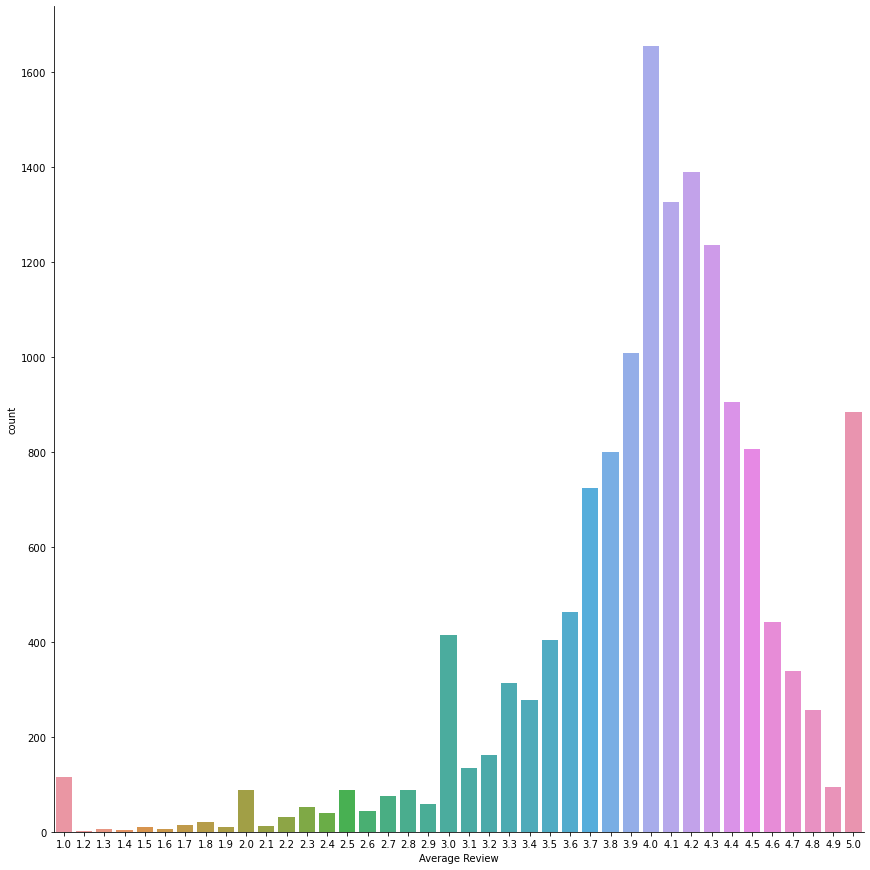

In [8]:
# Categorical plot without missing values
f = plt.figure(figsize = (24,24))
sb.catplot(x = 'Average Review', data = review, kind = "count", height = 12)
plt.show()

### Observation
The average reviews are left skewed, where the mean is 3.995 out of 5.0. Hence, the ratings may not be accurate and representative of the population. <br>
Another consideration is the number of reviews. A restaurant with a 5.0 rating, but only has a few number of reviews may not be as reliable as a restaurant with a high rating with high number of reviews. 

<ipython-input-9-f11adaa4011c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review['Average Review'] = review['Average Review'].round()


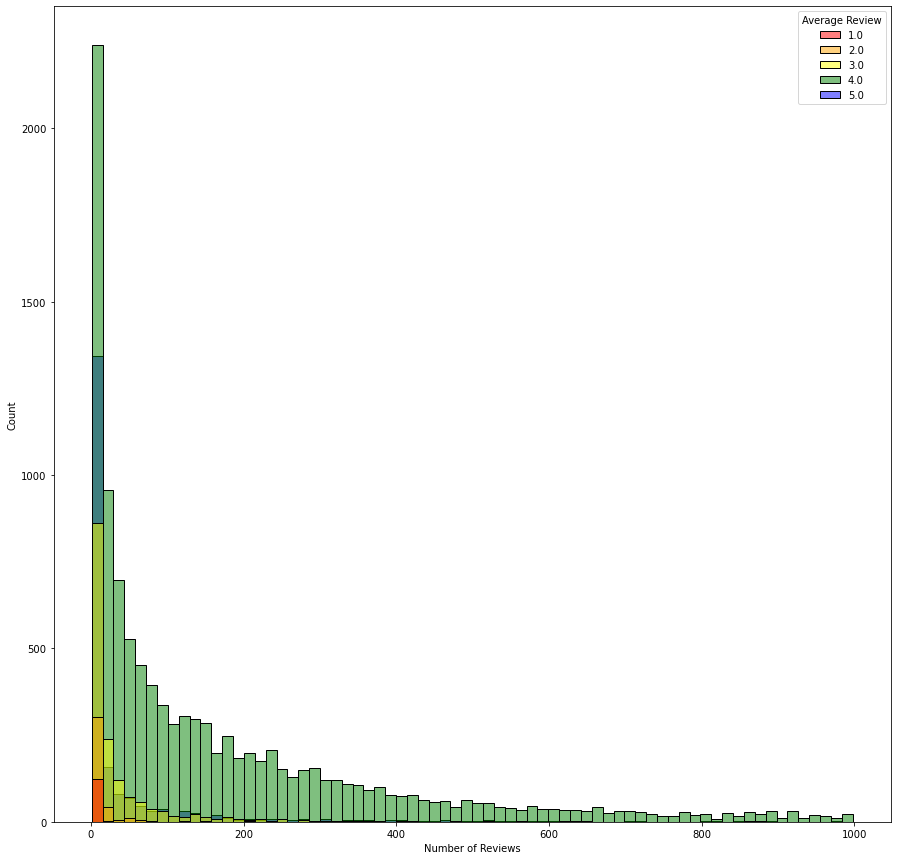

In [9]:
review['Average Review'] = review['Average Review'].round() 
plt.figure(figsize = (15,15))
sb.histplot(data = review, x = "Number of Reviews", hue = 'Average Review', palette=["red", "orange", "yellow", "green", "blue"])
plt.show()

Most restaurants, regardless of ratings, have a very low number of reviews, ranging approximately between 0 and 50.

Text(0.5, 1.0, 'Reviews count after cleaning')

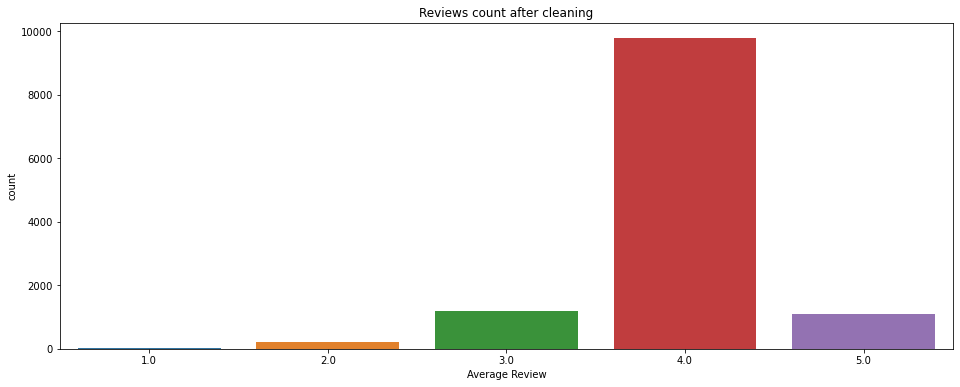

In [10]:
f = plt.figure(figsize = (16,6))
sb.countplot(data = review.loc[review["Number of Reviews"] >= 5], x = "Average Review").set_title("Reviews count after cleaning")

## 2. Generate Users

The data that we have scraped only consists of the stall name, cuisines, shop type, address, average review, and the number of reviews. This is insufficient as the recommendation system that we are building requires a matrix of users and their respective ratings on the various restaurants. <br>
Therefore, we will be doing a **Monte Carlo Simulation** to simulate the users' behavior over the course of a year, where they would visit and rate restaurants based on different characteristics. 

### Monte Carlo Simulation
During a Monte Carlo Simulation, values are sampled at random from the input probability distributions. Each set of samples is called an iteration, and the resulting outcome from that sample is recorded. Monte Carlo simulation does this hundreds or thousands of times, and the result is a probability distribution of possible outcomes. In this way, Monte Carlo simulation provides a much more comprehensive view of not only what could happen, but how likely it is to happen.

However, the way we did it was more like an event simulation, where the event that take place for each user will be dependent on each user's characteristics. This event simulation will take place over the course of a year, and each user will choose whether to go out to eat, and if they choose to do so, to also decide whether they would want to rate a restaurant. Their responses will be recorded which will be used later on for the recommendation.

In [11]:
users = pd.DataFrame(columns=['userId', 'character', 'age', 'address', 
                               'eatOut', 'drive', 'prRate', 'maxTravel'])

### Characteristics
UserId: Id of the user. <br>
Character: Strictness of a user when rating a restaurant. Higher = Stricter, Lower = Lenient (Between -0.5 and 0.5). <br>
Age: Between 18 - 75 (Working adults).<br>
Address: General address of the user (E.g. Tampines, Jurong, etc.).<br>
EatOut: Probability of a user going out to eat (Dependent on age).<br>
Drive: Whether a user drives (Dependent on age).<br>
PrRate: Probability of a user rating a restaurant (Dependent on age).<br>
MaxTravel: Max travel time a user is willing to spend (Dependent on age).<br>

Population: 2000 users will be created and they will mirror the population density of Singapore.
- For example, if 5% of the Singapore population stays in Tampines, then 100 out of the 2000 users will have an address located in Tampines. 

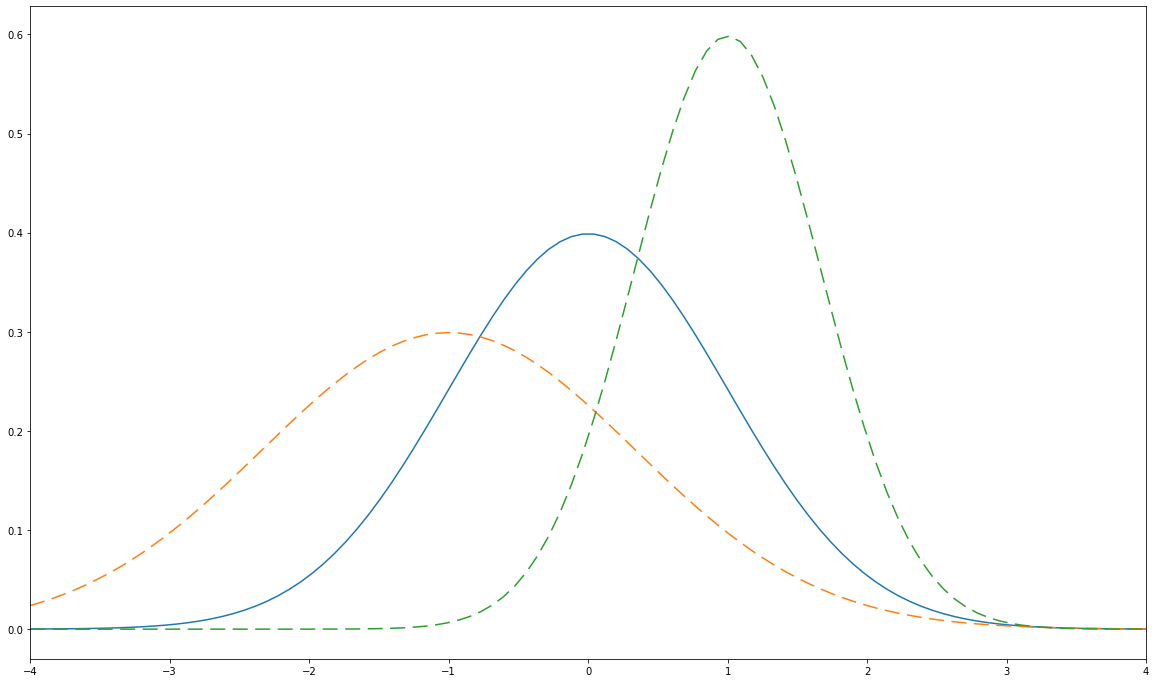

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

f = plt.figure(figsize = (20,12))
plt.xlim(-4.0, 4.0)
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x, stats.norm.pdf(x, -1, sigma/0.75), dashes=[10,5,10,5])

plt.plot(x, stats.norm.pdf(x, 1, sigma/1.5), dashes=[10,5,10,5])
plt.show()

### Calculating a user's possible score on a restautant
We will assume that the score of a restaurant will follow a normal distribution. A user's rating, will be based on probability accounting for their strictness value. <br>
A user with a higher strictness value (e.g. 0.5) will have an average of lower score with a greater spread, as seen from the orange graph.<br>
On the contrary, a user with lower strictness value (e.g. -0.5) will have an average of higher score with lower spread, as seen from the green graph.

In [13]:
users = pd.read_csv('3. Generate Users/userDf_new_V2.csv')
users.head()

,userId,character,age,address,eatOut,drive,prRate,maxTravel
0,0,-0.45,23,Jurong East,0.64,1,0.91,32
1,1,-0.39,69,Bedok,0.76,1,0.40,24
2,2,0.04,37,Woodlands,0.50,1,0.86,30
3,3,-0.34,37,Geylang,0.64,1,0.61,29
4,4,-0.25,18,Jurong West,0.72,0,0.72,54


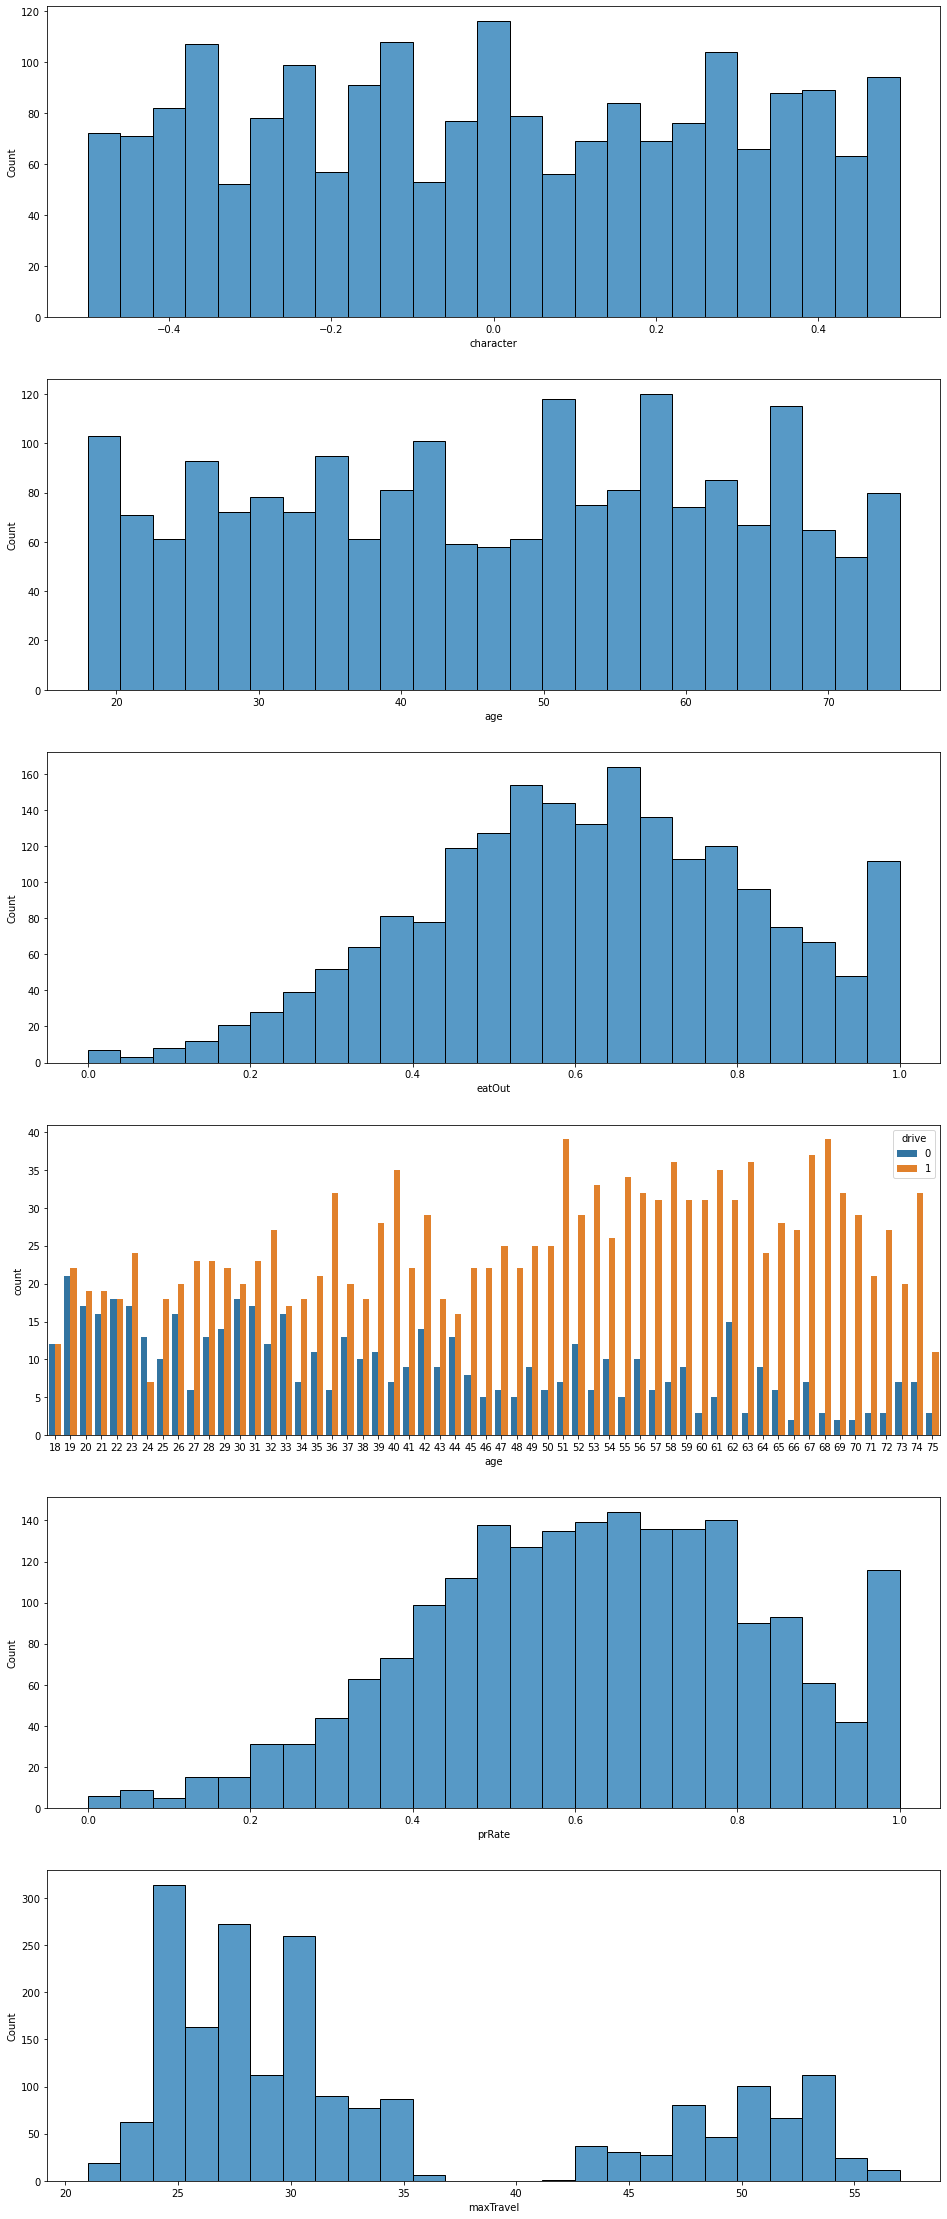

In [14]:
f, axes = plt.subplots(6, 1, figsize = (16, 40))
sb.histplot(data = users, x = 'character', bins = 25, ax = axes[0])
sb.histplot(data = users, x = 'age', bins = 25, ax = axes[1])
sb.histplot(data = users, x = 'eatOut', bins = 25, ax = axes[2])
sb.countplot(data = users, x = 'age', hue = 'drive', ax = axes[3])
sb.histplot(data = users, x = 'prRate', bins = 25, ax = axes[4])
sb.histplot(data = users, x = 'maxTravel', bins = 25, ax = axes[5])
plt.show()

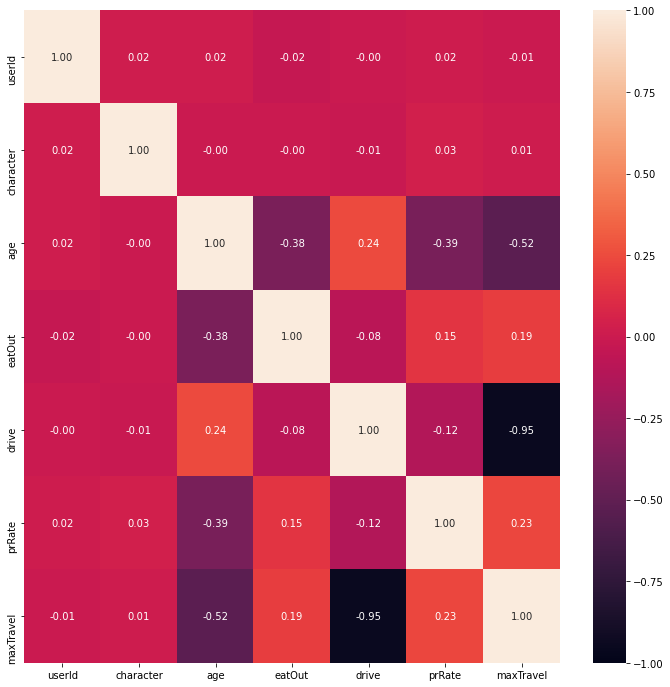

In [15]:
f = plt.figure(figsize = (12,12))
sb.heatmap(users.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")
plt.show()

Other considerations are very dependent on the age variable, as seen from the correlation. How likely a user chooses to eat out, rate a restaurant or how much time they are willing to travel are all dependent on how old a person is. 


## 3. Generate Distance/Time
To generate user reviews, we require the distance between the user and the restuarant beforehand. This distance is used to determine if the user is close enough to the restaurant. <br>
Our first approach was to scrape the distance between the two. However, it was taking too long and inefficient. <br>
Hence, we decided to use Google API to help us calculate the time and distance. 

### Get Distance Function

In [16]:
def get_distance(start_point, end_point, travel_type):

    gmaps = googlemaps.Client(key = "GoogleAPIK")

    if travel_type == 1:
        mode_ = "driving"
    else:
        mode_ = "transit"

    matrix = gmaps.distance_matrix(origins = start_point, destinations = end_point, mode = mode_)
    # print(matrix)
    distance = float(matrix['rows'][0]['elements'][0]['distance']['text'].split()[0])

    time = matrix['rows'][0]['elements'][0]['duration']['text']

    time = time.split()
    if(len(time) == 4):
        time = int(time[0])*60 + int(time[2])
    else:
        time = int(time[0])

    return time, distance

### 4. Generate Ratings 

Before our food recommender can predict user's ratings on stalls that have not been visited by them, we first need to generate reviews for stimulated users (reviews on stalls). Users with multiple Google food reviews are few. If we solely base our predictions on user data collected from Google, it would be hard and inaccurate to predict user's ratings (using Surpr!se recommendation system - collaborative user based filtering). Due to constraint in data available, our ratings is generated based on reviews of the stalls found on Google.<br>
For stalls with no reviews, the generated review would be between 0 to 5 as those stalls could either be a hidden gem or a horrible stall. Generation of review by any other way would otherwise be unreasonable. <br>


In [17]:
def generateRatings(char, placeid):
    global stallsdf
    
    avg = stallsdf.loc[placeid, "Average Review"] # Average Review
    num = stallsdf.loc[placeid, "Number of Reviews"] # Number of Reviews
    shiftedAvg = avg - char * avg
    
    if 10 <= num < 49: #between 25% and 50% percentile
        value = round(np.random.normal(loc=shiftedAvg, scale=1), 1) 
            
    elif 49 <= num < 187: #between 50% and 75% percentile
        value = round(np.random.normal(loc=shiftedAvg, scale=0.5), 1)
            
    elif num >= 187: #>75% percentile
        value = round(np.random.normal(loc=shiftedAvg, scale=0.25), 1)
    
    else: #below 25% percentile
        value = round(random.uniform(0,5), 1)
        
    if (char >= 0): #Strict - greater variance in review given
        value = round(np.random.normal(loc=value, scale=char*2), 1) #scale will be between 0 and 1
    else:
        value = round(np.random.normal(loc=value, scale=char*-0.5), 1) #0.25 <= scale < 0
    
    if value > 5:
        value = 5.0
    if value < 0:
        value = 0.0   
    
    return value

In [18]:
def update_review(placeid,review_given):
    global stallsdf
    
    current_score = stallsdf.loc[placeid, "Average Review"]
    current_reviewers = stallsdf.loc[placeid, "Number of Reviews"]
    
    total_current_score = current_reviewers * current_score
    
    new_reviewers = current_reviewers + 1
    new_score = (total_current_score + review_given)/new_reviewers
    
    df.loc[placeid, "Average Review"] = new_score
    df.loc[placeid, "Number of Reviews"] = new_reviewers

In [19]:
user_matrix = pd.read_csv('5. Generate Reviews/User Sparse Matrix.csv')
no_dups = user_matrix.drop_duplicates(subset = ["UserId", "StallId"], keep = False)
duplicates = user_matrix[user_matrix.duplicated(subset = ["UserId", "StallId"], keep = False)].sort_values(by = ["UserId", "StallId"], ignore_index = True)

In [20]:
index_ = (duplicates.groupby(["UserId", "StallId"]).mean().index)
values_ = (duplicates.groupby(["UserId", "StallId"]).mean().values)

In [21]:
reviews = pd.read_csv('5. Generate Reviews/User Reviews Final.csv')
reviews.head()

,UserId,StallId,Rating
0,0,12029,4.9
1,2,13862,4.0
2,3,5251,4.0
3,4,6612,4.6
4,5,15110,5.0


In [22]:
reviews.describe()

,UserId,StallId,Rating
count,281567.000000,281567.000000,281567.000000
mean,996.919479,10395.151747,3.192942
std,578.149980,6030.279829,1.454209
min,0.000000,0.000000,0.000000
25%,496.000000,5210.000000,2.100000
50%,991.000000,10370.000000,3.400000
75%,1497.000000,15625.000000,4.500000
max,1999.000000,20848.000000,5.000000


In [23]:
reviewCounts = list(reviews.UserId.value_counts())

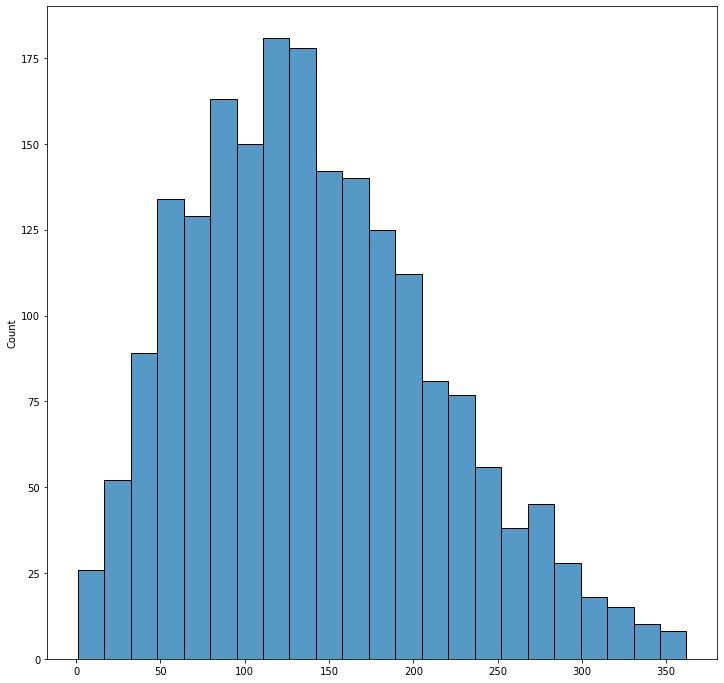

In [24]:
f = plt.figure(figsize=(12,12))
sb.histplot(reviewCounts)
plt.show()

In [25]:
import scipy.stats as sc
sum(reviewCounts)/len(reviewCounts)

140.9949924887331

In [26]:
q1, q3 = np.percentile(reviewCounts,[25,75])
iqr = sc.iqr(reviewCounts)
upper_bound = q3 + (1.5 * iqr) 
lst1 = list(reviews.UserId.value_counts())
lst2 = list(filter(lambda x: x > upper_bound,lst1))
lst2

[362, 361, 356, 356, 354, 353, 349, 349, 345, 343]

/Users/jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


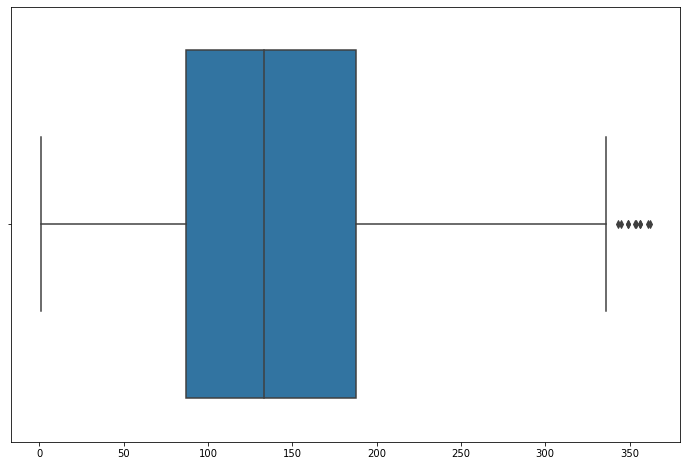

In [27]:
f = plt.figure(figsize = (12,8))
sb.boxplot(reviewCounts)
plt.show()

Hence, on average, each of our user will rate 140 restarants in a year, with 10 outliers, who voted more than 343 times in a year.